In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')



In [4]:
# Load the data
data_path = r'..\Data\data.csv' 
df = pd.read_csv(data_path, header=None)
df.head()

,0,1,2,3,4,5,6
0,NaN,Product_id,Category,Unit price,Date,Stock,Consommation
1,1.0,49672,PAT,3.7,2016-02-19,28800.0,13200.0
2,2.0,49672,PAT,2.96,2016-03-30,28800.0,13200.0
3,3.0,63570,VIEN,5.640016,2016-01-28,53100.0,10800.0
4,4.0,63499,VIEN,6.699968,2016-01-28,80352.0,10656.0


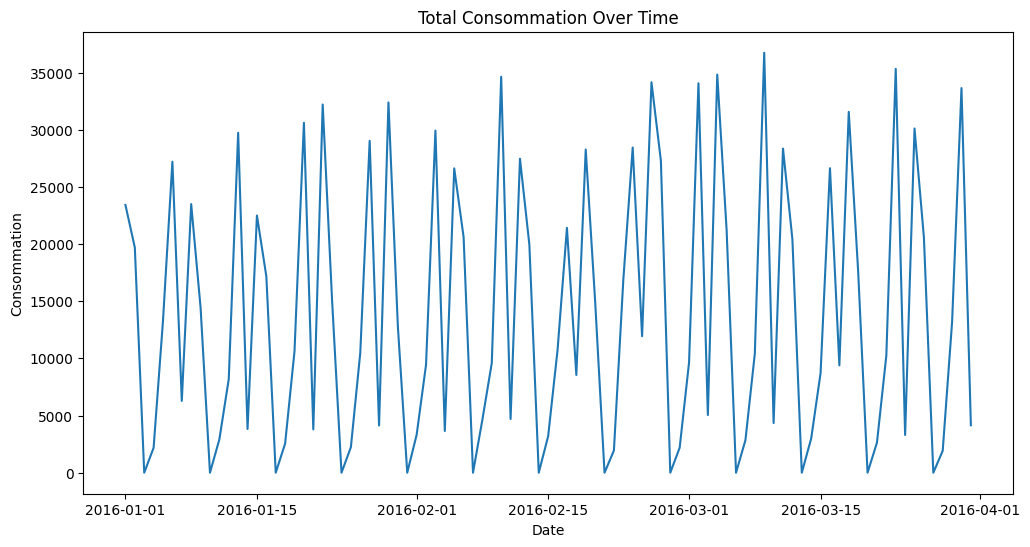

ADF Statistic: -1.8970491181159796
p-value: 0.33345056958983843
The time series is NOT stationary.


In [15]:
#Assign column names for clarity
df.columns = ['Index', 'ProductID', 'Category', 'Consommation', 'Date', 'Other1', 'Other2']

# Convert 'Date' to datetime and sort
df = df.sort_values('Date')

# Group by date and sum 'Consommation' (sales)
df['Consommation'] = pd.to_numeric(df['Consommation'], errors='coerce')
ts = df.groupby('Date')['Consommation'].sum()

# Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Total Consommation Over Time')
plt.xlabel('Date')
plt.ylabel('Consommation')
plt.show()

# Check stationarity with Augmented Dickey-Fuller test
result = adfuller(ts.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is NOT stationary.")


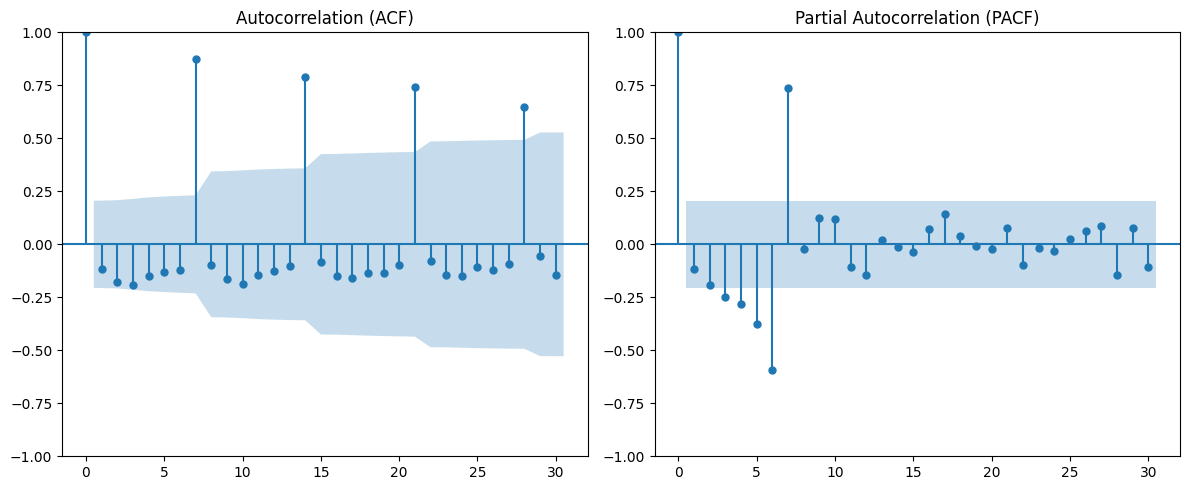

                                    SARIMAX Results                                    
Dep. Variable:                    Consommation   No. Observations:                   91
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -809.367
Date:                         Fri, 11 Jul 2025   AIC                           1628.733
Time:                                 00:10:24   BIC                           1640.828
Sample:                             01-01-2016   HQIC                          1633.592
                                  - 03-31-2016                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1801      0.143     -1.257      0.209      -0.461       0.101
ma.L1         -0.6760      0.106     -6.370      0.000     

In [21]:
# Plot ACF and PACF to help determine ARIMA parameters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(ts.dropna(), ax=plt.gca(), lags=30)
plt.title('Autocorrelation (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(ts.dropna(), ax=plt.gca(), lags=30, method='ywm')
plt.title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

# Fit the ARIMA model (example order, adjust based on ACF/PACF)
model = ARIMA(ts, order=(1,1,1), seasonal_order=(1,1,1,7))
model_fit = model.fit()
print(model_fit.summary())

### Model Diagnostics

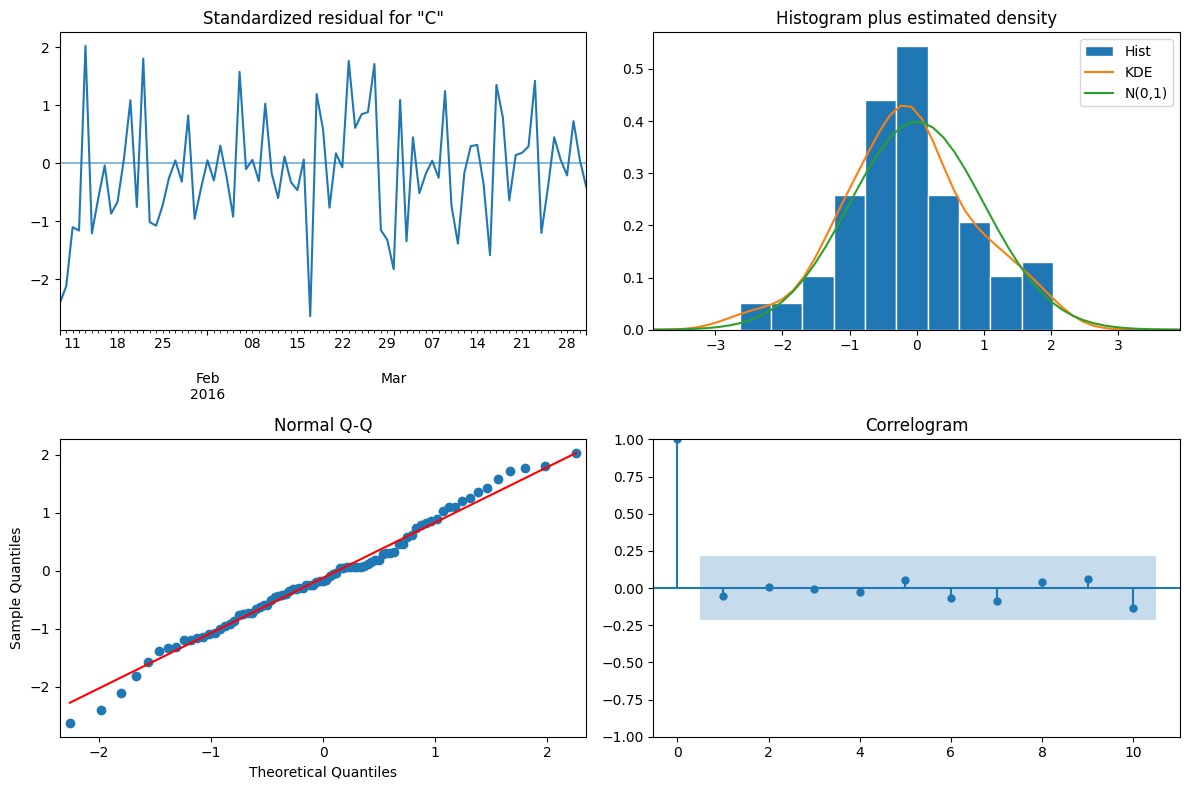

In [22]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

## Forecast Future Values

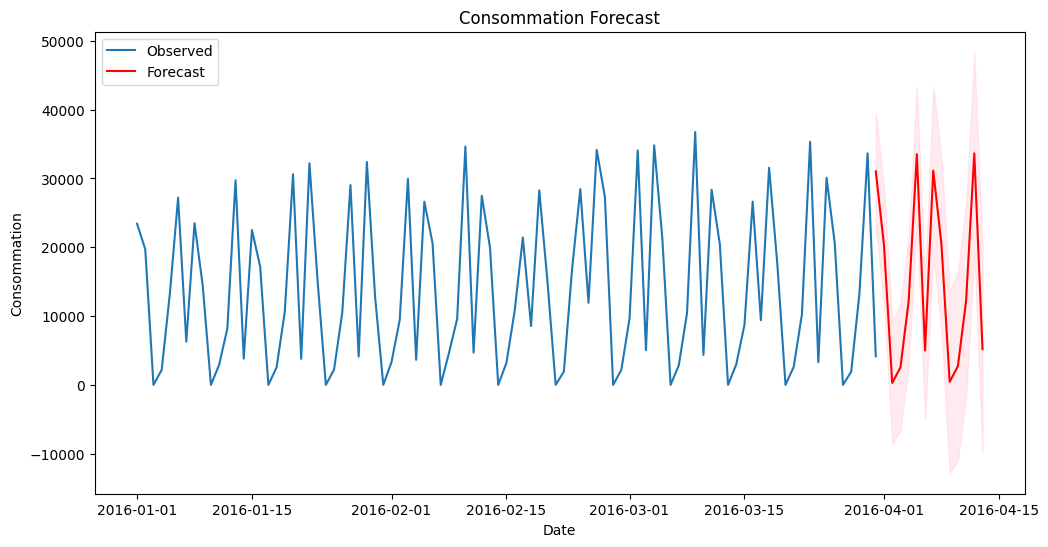

In [25]:
n_periods = 14  # Number of days to forecast (change as needed)
forecast = model_fit.get_forecast(steps=n_periods)
forecast_index = pd.date_range(ts.index[-1], periods=n_periods, freq="D")

# Get forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Consommation Forecast')
plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()
plt.show()